In [1]:
import tensorflow as tf
print('Tensor flow version: ', tf.__version__)
# set the gpu grow params for preventing the memory blow up
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
#load other modules
import cv2 as cv
import matplotlib.pyplot as plt
from PIL import Image
import csv
import glob
import numpy as np
%matplotlib inline
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
print('modules imported successfully')

/home/hsaeidi/.local/lib/python2.7/site-packages/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)


('Tensor flow version: ', '2.1.0')
(1, 'Physical GPUs,', 1, 'Logical GPUs')
modules imported successfully


In [2]:
# Read the csv files and images
print('Step 1: reading images and labels')

samples = []
images = []

# number of collected datasets
data_set_no = 2
data_set_len = np.zeros(data_set_no, dtype = np.int16)

for i in range(data_set_no):
    label_file_name = '/home/hsaeidi/nn_data_for_breathing_tracker/set' + str((i+1))+'/labels/lebels.csv' 
    with open(label_file_name) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            samples.append(line)
    if i == 0:
        data_set_len[i] = len(samples)
    else:
        data_set_len[i] = len(samples) - np.sum(data_set_len)
    
    address_name = '/home/hsaeidi/nn_data_for_breathing_tracker/set' + str((i+1))+'/images/img'
    for j in range(data_set_len[i]):
        tmp = address_name + str((j+1)) +'.png'
        images.append(tmp)
#read images # read the image addresses
print('data set lengths ')
print(data_set_len)
sample_size = len(samples)	
print('Total number of collected samples: ',sample_size)
images_no = len(images)
print('Total number of image addresses: ', images_no)


Step 1: reading images and labels
data set lengths 
[2006 1551]
('Total number of collected samples: ', 3557)
('Total number of image addresses: ', 3557)


The sample image size is
(128, 128)
 and it contains this type of data
[[29 30 30 ... 23 24 25]
 [28 28 26 ... 21 23 23]
 [29 28 28 ... 22 22 23]
 ...
 [23 23 24 ... 20 21 21]
 [25 23 23 ... 21 21 22]
 [23 24 23 ... 21 22 21]]
with min and max equal to:
19
255
when normalized it gets like this
[[0.11372549 0.11764706 0.11764706 ... 0.09019608 0.09411765 0.09803922]
 [0.10980392 0.10980392 0.10196078 ... 0.08235294 0.09019608 0.09019608]
 [0.11372549 0.10980392 0.10980392 ... 0.08627451 0.08627451 0.09019608]
 ...
 [0.09019608 0.09019608 0.09411765 ... 0.07843137 0.08235294 0.08235294]
 [0.09803922 0.09019608 0.09019608 ... 0.08235294 0.08235294 0.08627451]
 [0.09019608 0.09411765 0.09019608 ... 0.08235294 0.08627451 0.08235294]]
with min and max equal to:
0.07450980392156863
1.0


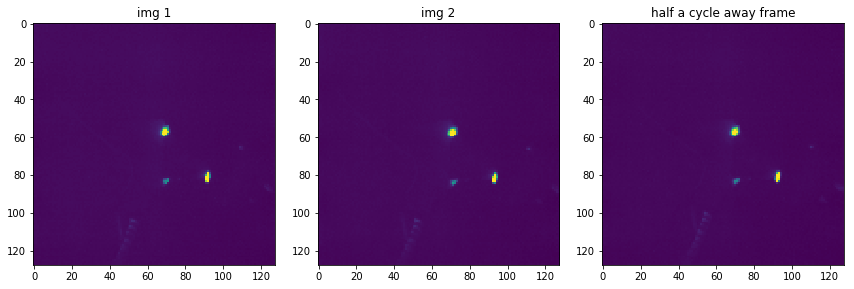

In [3]:
# read some sample images for a quick test
img1 = Image.open(str(images[0]))
img2 = Image.open(str(images[63]))

print('The sample image size is')
print(img1.size)
print(' and it contains this type of data')
print(np.asarray(img1))
print('with min and max equal to:')
print(np.amin(img1))
print(np.amax(img1))
print('when normalized it gets like this')
img1_norm = np.asarray(img1)/float(255) 
print(img1_norm)
print('with min and max equal to:')
print(np.amin(img1_norm))
print(np.amax(img1_norm))


#plot 2 of them
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(img1)
plt.title('img 1')
plt.subplot(132)
plt.imshow(img2)
plt.title('img 2')


plt.subplot(133)
img_last = Image.open(str(images[86]))
plt.imshow(img_last)
plt.title('half a cycle away frame')
fig.tight_layout()

[2006 3557]
[   0 2006 3557]
finished preprocessing data
('size of train data after calculations ', 1761)
(' and totally ', 880, ' breathing samples vs', 881, ' stopped breathing samples')
---------
1761
0
---------
moving fl with min and max equal to:
(-0.9058823529411765, 0.8784313725490196)
moving sum with min and max equal to:
(-0.8296918767507002, 0.9305322128851541)
stopped fl with min and max equal to:
(-0.8980392156862745, 0.8862745098039215)
stopped sum with min and max equal to:
(-0.8302521008403361, 0.9938375350140056)
train data size and type:
1408
<type 'numpy.ndarray'>
shape of normalized train inputs
(1408, 128, 128, 2)
shape of train outputs
(1408, 2)
shape of normalized validation inputs
(353, 128, 128, 2)
shape of validation outputs
(353, 2)


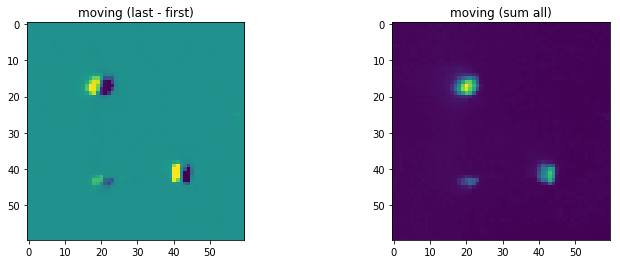

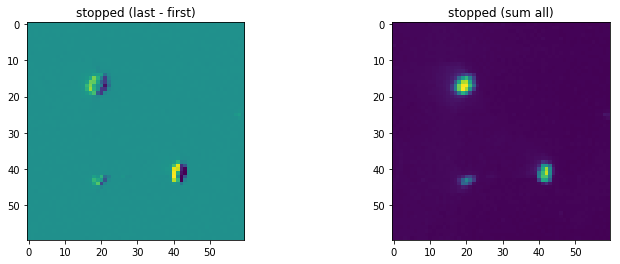

In [4]:
# preparing some quick training data
# input before preprocessing
x_raw = []
# output before preprocessing
y_raw = []

# number of moving samples
moving_no = 0
#number of stopped samples
stopped_no = 0

data_offset = np.cumsum(data_set_len)
print(data_offset)

data_offset = np.insert(data_offset, 0, 0)
print(data_offset)

# horizon for 2 seconds of data with freq: 7 hz
t_h = 14
t_h_1 = t_h -1



# start reading and preprocessing the last 14 frames into different cumulative channels
for k in range(data_set_no):
    for i in range(data_offset[k] + t_h_1 , data_offset[k+1]):
        x_sum = np.asarray(Image.open(str(images[i])))/float(255)
        x_last2first = np.asarray(Image.open(str(images[i])))/float(255) - np.asarray(Image.open(str(images[i-t_h_1])))/float(255)
        for j in range(1,t_h):
            img_tmp = Image.open(str(images[i-j]))
            x_sum += np.asarray(img_tmp)/float(255)
        img_combined = cv.merge((x_last2first, (x_sum-7)*2/float(t_h)))
        # put the corresponding label: 1 when stopped breathing and 0 when breathing
        if samples[i] == ['1']:
            y_label = [0.0, 1.0]
            x_raw.append(img_combined)
            y_raw.append(y_label)
            stopped_no += 1    
            #print('a stopped breathing sample')
        else:
            y_label = [1.0, 0.0]  
            #downsample the moving frames (we have 3 times as many)
            if (i%3) == 0:
                x_raw.append(img_combined)
                y_raw.append(y_label)
                moving_no += 1
print('finished preprocessing data')

print('size of train data after calculations ',len(x_raw))
#print(' which is the total of ', sample_size, ' minus ', data_set_no,'x', '= ', data_set_no*13 )
print(' and totally ', moving_no, ' breathing samples vs', stopped_no, ' stopped breathing samples')
print('---------')
stopped_index = 0
print(len(y_raw))
y_tmp = np.array(y_raw)
for i in range(0,len(y_tmp)):
    #print(i)
    #print(y_tmp[i])
    if y_tmp[i][1] == '1.0':
        stopped_index = i
        break
print(stopped_index)
print('---------')
hor_ii = 50
hor_ie = 110
ver_ii = 40
ver_ie = 100
fig = plt.figure(figsize=(12,4))

plt.subplot(121)
moving_fl = x_raw[stopped_index+t_h][ver_ii:ver_ie,hor_ii:hor_ie,0]
plt.imshow(moving_fl)
print('moving fl with min and max equal to:')
print(np.amin(moving_fl),np.amax(moving_fl))
plt.title('moving (last - first)')
plt.subplot(122)
moving_sum = x_raw[stopped_index+t_h][ver_ii:ver_ie,hor_ii:hor_ie,1]
plt.imshow(moving_sum)
print('moving sum with min and max equal to:')
print(np.amin(moving_sum),np.amax(moving_sum))
plt.title('moving (sum all)')

fig = plt.figure(figsize=(12,4))
plt.subplot(121)
stopped_fl = x_raw[stopped_index][ver_ii:ver_ie,hor_ii:hor_ie,0]
plt.imshow(stopped_fl)
print('stopped fl with min and max equal to:')
print(np.amin(stopped_fl),np.amax(stopped_fl))
plt.title('stopped (last - first)')
plt.subplot(122)
stopped_sum = x_raw[stopped_index][ver_ii:ver_ie,hor_ii:hor_ie,1]
plt.imshow(stopped_sum)
print('stopped sum with min and max equal to:')
print(np.amin(stopped_sum),np.amax(stopped_sum))
plt.title('stopped (sum all)')
          
          
x_train, x_val, y_train, y_val = train_test_split(x_raw, y_raw, test_size=0.2, random_state=1, shuffle= True)

print('train data size and type:')
print(len(x_train))
print(type(x_train[0]))
#print(x_train[0])
#print(y_train[0])


x_train = np.array(x_train)
print('shape of normalized train inputs')
print(x_train.shape)
y_train = np.array(y_train)
print('shape of train outputs')
print(y_train.shape)

x_val = np.array(x_val)
print('shape of normalized validation inputs')
print(x_val.shape)
y_val = np.array(y_val)
print('shape of validation outputs')
print(y_val.shape)


In [5]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD


ch, row, col = 2, 128, 128  # image format

# Neural network architecture
model = Sequential()
# convolution layers that gradually become deeper
model.add(Conv2D(24, kernel_size = (5, 5), strides =(2,2), padding='same', activation='relu', input_shape=(row, col, ch)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(36, kernel_size = (5, 5), strides =(2,2), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(48, kernel_size = (5, 5), strides =(2,2), padding='same', activation='relu'))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size = (3, 3), strides =(2,2), padding='same', activation='relu'))
model.add(Dropout(0.25))
#removed temp:model.add(Conv2D(64, kernel_size = (3, 3), strides =(2,2), padding='same', activation='relu'))
#removed temp:model.add(Dropout(0.25))
# flattening the outputs and using dense layers up to the final output (i.e. steering angle)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='relu'))
# outputting the moving/stopped
model.add(Dense(2, activation='softmax'))
print('model defined')
model.summary()

#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(optimizer='adam',  # Optimizer
              # Loss function to minimize
              #loss='binary_crossentropy',
              loss='categorical_crossentropy',
              # List of metrics to monitor
              metrics=["accuracy"])
print('compiled the model')

model defined
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 24)        1224      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 24)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 24)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 36)        21636     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 36)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 36)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 

In [8]:
print('training started')
history = model.fit(x_train, y_train,
		                batch_size=512,
		                epochs=200,
                        shuffle=True,
		                # We pass some validation for
		                # monitoring validation loss and metrics
		                # at the end of each epoch
		                validation_data=(x_val, y_val))


training started
Train on 1408 samples, validate on 353 samples
Epoch 1/200
1408/1408 [==============================] - 1s 593us/sample - loss: 0.2694 - accuracy: 0.9247 - val_loss: 0.3918 - val_accuracy: 0.8895
Epoch 2/200
1408/1408 [==============================] - 1s 495us/sample - loss: 0.2506 - accuracy: 0.9368 - val_loss: 0.3835 - val_accuracy: 0.8839
Epoch 3/200
1408/1408 [==============================] - 1s 492us/sample - loss: 0.2671 - accuracy: 0.9261 - val_loss: 0.3882 - val_accuracy: 0.8867
Epoch 4/200
1408/1408 [==============================] - 1s 488us/sample - loss: 0.2549 - accuracy: 0.9290 - val_loss: 0.3986 - val_accuracy: 0.8867
Epoch 5/200
1408/1408 [==============================] - 1s 511us/sample - loss: 0.2399 - accuracy: 0.9368 - val_loss: 0.4064 - val_accuracy: 0.8782
Epoch 6/200
1408/1408 [==============================] - 1s 514us/sample - loss: 0.2590 - accuracy: 0.9276 - val_loss: 0.4043 - val_accuracy: 0.8839
Epoch 7/200
1408/1408 [===================

1408/1408 [==============================] - 1s 530us/sample - loss: 0.2300 - accuracy: 0.9439 - val_loss: 0.3782 - val_accuracy: 0.8924
Epoch 56/200
1408/1408 [==============================] - 1s 501us/sample - loss: 0.2169 - accuracy: 0.9425 - val_loss: 0.3783 - val_accuracy: 0.8867
Epoch 57/200
1408/1408 [==============================] - 1s 506us/sample - loss: 0.2158 - accuracy: 0.9439 - val_loss: 0.3898 - val_accuracy: 0.8810
Epoch 58/200
1408/1408 [==============================] - 1s 530us/sample - loss: 0.2216 - accuracy: 0.9411 - val_loss: 0.3938 - val_accuracy: 0.8725
Epoch 59/200
1408/1408 [==============================] - 1s 568us/sample - loss: 0.2194 - accuracy: 0.9432 - val_loss: 0.4016 - val_accuracy: 0.8782
Epoch 60/200
1408/1408 [==============================] - 1s 530us/sample - loss: 0.2196 - accuracy: 0.9403 - val_loss: 0.4071 - val_accuracy: 0.8924
Epoch 61/200
1408/1408 [==============================] - 1s 537us/sample - loss: 0.2289 - accuracy: 0.9403 - val

1408/1408 [==============================] - 1s 531us/sample - loss: 0.1749 - accuracy: 0.9560 - val_loss: 0.4210 - val_accuracy: 0.8725
Epoch 110/200
1408/1408 [==============================] - 1s 557us/sample - loss: 0.1848 - accuracy: 0.9581 - val_loss: 0.4275 - val_accuracy: 0.8810
Epoch 111/200
1408/1408 [==============================] - 1s 515us/sample - loss: 0.1593 - accuracy: 0.9645 - val_loss: 0.4583 - val_accuracy: 0.8754
Epoch 112/200
1408/1408 [==============================] - 1s 494us/sample - loss: 0.1773 - accuracy: 0.9517 - val_loss: 0.4253 - val_accuracy: 0.8640
Epoch 113/200
1408/1408 [==============================] - 1s 499us/sample - loss: 0.1700 - accuracy: 0.9602 - val_loss: 0.4215 - val_accuracy: 0.8725
Epoch 114/200
1408/1408 [==============================] - 1s 495us/sample - loss: 0.1780 - accuracy: 0.9531 - val_loss: 0.4586 - val_accuracy: 0.8754
Epoch 115/200
1408/1408 [==============================] - 1s 515us/sample - loss: 0.1765 - accuracy: 0.9560

1408/1408 [==============================] - 1s 505us/sample - loss: 0.1482 - accuracy: 0.9645 - val_loss: 0.4558 - val_accuracy: 0.8839
Epoch 164/200
1408/1408 [==============================] - 1s 502us/sample - loss: 0.1453 - accuracy: 0.9680 - val_loss: 0.4508 - val_accuracy: 0.8867
Epoch 165/200
1408/1408 [==============================] - 1s 491us/sample - loss: 0.1559 - accuracy: 0.9609 - val_loss: 0.4328 - val_accuracy: 0.8810
Epoch 166/200
1408/1408 [==============================] - 1s 493us/sample - loss: 0.1443 - accuracy: 0.9680 - val_loss: 0.4600 - val_accuracy: 0.8839
Epoch 167/200
1408/1408 [==============================] - 1s 521us/sample - loss: 0.1494 - accuracy: 0.9659 - val_loss: 0.4457 - val_accuracy: 0.8782
Epoch 168/200
1408/1408 [==============================] - 1s 497us/sample - loss: 0.1538 - accuracy: 0.9602 - val_loss: 0.4529 - val_accuracy: 0.8782
Epoch 169/200
1408/1408 [==============================] - 1s 502us/sample - loss: 0.1473 - accuracy: 0.9638

In [9]:
model.save('../saved_models/reduced_model') 

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ../saved_models/reduced_model/assets
